# Manning liveProject: Deploy DL Model on Web & Mobile Using TensorFlow
---
## Milestone 1: Build an image classifier
## Solutions Notebook
---
#### Date updated:  23-Jan-2021
#### Author:  Nidhin Pattaniyil & Reshama Shaikh


In [1]:
from datetime import date
from datetime import datetime

current_date = date.today()
print("Today's date:", current_date)

Today's date: 2021-01-16


In [2]:
now1 = datetime.now()

start_time = now1.strftime("%H:%M:%S")
print("Start Time =", start_time)

Start Time = 18:33:34


In [3]:
# run this once (each session) if `watermark` library is not loaded, then comment out
# If you see errors for the library albumentations and datascience, it can be ignored. These libraries are not used for this project. 
!pip install watermark tensorflow==2.3.* -q

     |████████████████████████████████| 320.4MB 55kB/s 
     |████████████████████████████████| 20.1MB 81.6MB/s 
     |████████████████████████████████| 460kB 58.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [4]:
# import libraries
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from pprint import pprint


In [5]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
import tensorflow as tf
import pathlib
import tensorflow_hub as hub

In [7]:
import watermark
%load_ext watermark
#%reload_ext watermark

In [8]:
# see version of system, python and libraries
%watermark -n -v -m -g -iv

PIL.Image      7.0.0
watermark      2.0.2
tensorflow_hub 0.11.0
requests       2.23.0
numpy          1.19.5
tensorflow     2.3.2
json           2.0.9
Sat Jan 16 2021 

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   :


In [9]:
tf.__version__


'2.3.2'

# Running GPU on Colab
Ensure that GPU is running on this Colab notebook by following below steps.
1. Colab Menu: Select "Runtime"
2. "Change runtime type"
3. Select "Hardware Accelerator" = GPU
4. Save

In [10]:
# confirm that GPU is running
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Setup Project Folder

In [12]:
!pwd

/content


In [13]:
!ls -lF

total 4
drwxr-xr-x 1 root root 4096 Jan  6 18:10 sample_data/


In [14]:
PROJECT_NAME = "project_food_dl"

In [15]:
# create a sub-directory for the data
# run this once and comment out
!mkdir -p {PROJECT_NAME}

In [16]:
!ls -lF

total 8
drwxr-xr-x 2 root root 4096 Jan 16 18:34 project_food_dl/
drwxr-xr-x 1 root root 4096 Jan  6 18:10 sample_data/


In [17]:
!ls -lF {PROJECT_NAME}

total 0


In [18]:
# remove log files from models
!rm -rf {PROJECT_NAME}/artifacts


In [19]:
!rm -rf {PROJECT_NAME}/data/food-101.tar.gz

In [20]:
!rm -f artifacts.zip

In [21]:
# create a sub-directory for data
!mkdir -p {PROJECT_NAME}/data

In [22]:
!ls {PROJECT_NAME} -lF

total 4
drwxr-xr-x 2 root root 4096 Jan 16 18:34 data/


Artifacts is common ML term used to describe the output created by the training process.

The output could be a fully trained model, a model checkpoint (for resuming training later), or simply a file created during the training process such as an image generated while training a Generative Adversarial Network (GAN).  
In the case of a Deep Learning model, the model artifacts are the trained weights stored in a binary format.


In [23]:
# create a sub-directory for artifacts
!mkdir -p {PROJECT_NAME}/artifacts

In [24]:
!ls {PROJECT_NAME} -lF

total 8
drwxr-xr-x 2 root root 4096 Jan 16 18:34 artifacts/
drwxr-xr-x 2 root root 4096 Jan 16 18:34 data/


# Get Data

In [25]:
! wget https://lp-prod-resources.s3-us-west-2.amazonaws.com/other/Deploying+a+Deep+Learning+Model+on+Web+and+Mobile+Applications+Using+TensorFlow/Food+101+-+Data+Subset.zip -P {PROJECT_NAME}/data


--2021-01-16 18:34:54--  https://lp-prod-resources.s3-us-west-2.amazonaws.com/other/Deploying+a+Deep+Learning+Model+on+Web+and+Mobile+Applications+Using+TensorFlow/Food+101+-+Data+Subset.zip
Resolving lp-prod-resources.s3-us-west-2.amazonaws.com (lp-prod-resources.s3-us-west-2.amazonaws.com)... 52.218.152.137
Connecting to lp-prod-resources.s3-us-west-2.amazonaws.com (lp-prod-resources.s3-us-west-2.amazonaws.com)|52.218.152.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153668842 (147M) [application/zip]
Saving to: ‘project_food_dl/data/Food+101+-+Data+Subset.zip’

Food+101+-+Data+Sub 100%[===================>] 146.55M  82.7MB/s    in 1.8s    

2021-01-16 18:34:56 (82.7 MB/s) - ‘project_food_dl/data/Food+101+-+Data+Subset.zip’ saved [153668842/153668842]



In [26]:
# unpack the data
# run only once, then comment out 

!unzip -q {PROJECT_NAME}/data/Food+101+-+Data+Subset.zip -d {PROJECT_NAME}/data


In [27]:
!ls {PROJECT_NAME} -lF

total 8
drwxr-xr-x 2 root root 4096 Jan 16 18:34 artifacts/
drwxr-xr-x 4 root root 4096 Jan 16 18:34 data/


In [28]:
DATA_DIR = str(PROJECT_NAME)+"/data/food-101-subset/images"
DATA_DIR = pathlib.Path(DATA_DIR)

In [29]:
!rm -rf {DATA_DIR}/.DS_Store

In [30]:
DATA_DIR


PosixPath('project_food_dl/data/food-101-subset/images')

# Look at dataset

In [31]:
# look at folder names
!ls -lah {DATA_DIR}/ | head 

total 128K
drwxr-xr-x 5 root root 4.0K Jan 16 18:34 .
drwxr-xr-x 3 root root 4.0K Dec  5 15:07 ..
drwxr-xr-x 2 root root  36K Dec  5 15:00 apple_pie
drwxr-xr-x 2 root root  36K Dec  5 15:00 caesar_salad
drwxr-xr-x 2 root root  36K Dec  5 15:00 falafel


In [32]:
# look at first five images in first image folder
!ls {DATA_DIR}/apple_pie | head -5

1005649.jpg
1011328.jpg
101251.jpg
1014775.jpg
1026328.jpg


In [33]:
# find out how many total images there are in database
image_count = len(list(DATA_DIR.glob('*/*.jpg')))
image_count

3000

In [34]:
# find out how many different classes there are
ALL_CLASS_NAMES = sorted(np.array([item.name for item in DATA_DIR.glob('*')]))
print(len(ALL_CLASS_NAMES))

3


In [35]:
ALL_CLASS_NAMES[:10]

['apple_pie', 'caesar_salad', 'falafel']

In [36]:
 USE_CLASS_NAMES = ALL_CLASS_NAMES

# Look at Images

In [37]:
class1 = ALL_CLASS_NAMES[0]

Image Size (w, h):  512 , 512
project_food_dl/data/food-101-subset/images/apple_pie/3277765.jpg


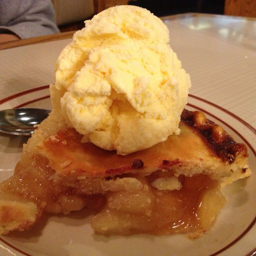

Image Size (w, h):  512 , 384
project_food_dl/data/food-101-subset/images/apple_pie/854595.jpg


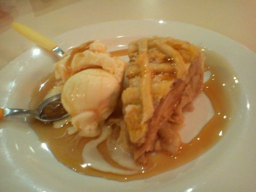

In [38]:
images = list(DATA_DIR.glob(f'{class1}/*'))

for image_path in images[:2]:
    # resize image
    im = Image.open(str(image_path))
    w, h = im.size
    print('Image Size (w, h): ', w, ",",  h)
    print (image_path)
    percent_resize = 0.5
    im = im.resize((int(w*percent_resize), int(h*percent_resize)))
    display.display(im)

# Setup for Training Model


The `ImageDataGenerator` is used to create training and validation splits.
It also has several builtin image preprocessing transformations. 

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [39]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

print("Number of classes we are training: " ,len(USE_CLASS_NAMES))
print("\nList of classes")  
list(USE_CLASS_NAMES)[:10]

Number of classes we are training:  3

List of classes


['apple_pie', 'caesar_salad', 'falafel']

In [40]:
def get_image_data_generator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input ):
  image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocessing_function
  )



  # create a data generator object with options (location of images, batch size, option to shuffle, etc)
  image_data_gen = image_generator.flow_from_directory(
      directory=str(DATA_DIR),
      batch_size=BATCH_SIZE,
      shuffle=True,
      target_size=(IMG_HEIGHT, IMG_WIDTH),
      classes = list(USE_CLASS_NAMES)
      )

  return image_data_gen

In [41]:
image_data_gen = get_image_data_generator (preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

Found 3000 images belonging to 3 classes.


# Save list of classes as `classes.json`

In [42]:
image_data_gen.num_classes

3

In [43]:
image_data_gen.class_indices.keys()

dict_keys(['apple_pie', 'caesar_salad', 'falafel'])

In [44]:
list_of_classes = list(image_data_gen.class_indices.keys())

In [45]:
list_of_classes

['apple_pie', 'caesar_salad', 'falafel']

In [46]:
with open(f"{PROJECT_NAME}/artifacts/classes.json",'w') as f:
  json.dump(list_of_classes,f)

---

# Model Architectures

### Model 1:  VGG19 (Baseline)

In [47]:
?tf.keras.layers.Dense

In [48]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

# Use VGG19 pretrained on ImageNet
base_layers = tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=IMAGE_SHAPE+(3,) )

# Add new layers to be finetuned
# The last layer, is the classification layer and should match the number of classes in the dataset. The activation should be softmax 
clf = tf.keras.Sequential([
    base_layers
    , tf.keras.layers.GlobalAveragePooling2D()
    , tf.keras.layers.Dense(1024, activation='relu')
    , tf.keras.layers.Dense(image_data_gen.num_classes , name='classification', activation='softmax')
])

80142336/80134624 [==============================] - 1s 0us/step


In [49]:
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 20,552,771
Trainable params: 20,552,771
Non-trainable params: 0
_________________________________________________________________


In [50]:
# freezes the base layers
base_layers.trainable = False

In [51]:
# notice that after freezing the base layers, the non trainable params are equal to the number of parameters in the base layer 
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 20,552,771
Trainable params: 528,387
Non-trainable params: 20,024,384
_________________________________________________________________


In [52]:
# Set the model to use Adam optimizer , cross entropy loss, and track accuracy.
# Since the dataset has multiple classes, we are using cross entropy loss.
clf.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy' ,
  metrics=['acc'])

#### Model results

In [53]:
# train the model for 5 epochs
%%time
image_data_gen = get_image_data_generator (preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
history = clf.fit(image_data_gen
                        ,epochs=5
                        ,workers=8 
                        )


Found 3000 images belonging to 3 classes.
Epoch 1/5
94/94 [==============================] - 15s 158ms/step - loss: 0.8460 - acc: 0.8523
Epoch 2/5
94/94 [==============================] - 14s 152ms/step - loss: 0.2445 - acc: 0.9370
Epoch 3/5
94/94 [==============================] - 15s 156ms/step - loss: 0.1585 - acc: 0.9463
Epoch 4/5
94/94 [==============================] - 15s 161ms/step - loss: 0.0954 - acc: 0.9697
Epoch 5/5
94/94 [==============================] - 15s 165ms/step - loss: 0.0386 - acc: 0.9837
CPU times: user 2min 2s, sys: 7.32 s, total: 2min 9s
Wall time: 1min 31s


#### Save model

In [54]:
# save the model as `h5` format
export_path = str(PROJECT_NAME)+"/artifacts/model_VGG19.h5"
export_path
clf.save(export_path, save_format='h5')


### Model 2:  ResNet50
On your own, train a model using ResNet50.

In [55]:
base_layers = tf.keras.applications.ResNet50(weights='imagenet',include_top=False,input_shape=IMAGE_SHAPE+(3,) )

# Add new layers to be finetuned
# The last layer, is the classification layer and should match the number of classes in the dataset. The activation should be softmax 
clf = tf.keras.Sequential([
    base_layers
    , tf.keras.layers.GlobalAveragePooling2D()
    , tf.keras.layers.Dense(1024, activation='relu')
    , tf.keras.layers.Dense(image_data_gen.num_classes , name='classification', activation='softmax')
])


94773248/94765736 [==============================] - 1s 0us/step


In [56]:
clf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 25,688,963
Trainable params: 25,635,843
Non-trainable params: 53,120
_________________________________________________________________


In [57]:
# freezes the base layers
base_layers.trainable = False

In [58]:
# notice that after freezing the base layers, the non trainable params are equal to the number of parameters in the base layer 
clf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 25,688,963
Trainable params: 2,101,251
Non-trainable params: 23,587,712
_________________________________________________________________


In [59]:
# Set the model to use Adam optimizer , cross entropy loss, and track accuracy.
# Since the dataset has multiple classes, we are using cross entropy loss.
clf.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy' ,
  metrics=['acc'])

In [60]:
# train the model for 5 epochs
%%time
image_data_gen = get_image_data_generator (preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

history = clf.fit(image_data_gen
                        ,epochs=5
                        ,workers=8 
                        )

Found 3000 images belonging to 3 classes.
Epoch 1/5
94/94 [==============================] - 12s 130ms/step - loss: 0.5434 - acc: 0.8530
Epoch 2/5
94/94 [==============================] - 12s 130ms/step - loss: 0.1628 - acc: 0.9347
Epoch 3/5
94/94 [==============================] - 12s 131ms/step - loss: 0.1102 - acc: 0.9573
Epoch 4/5
94/94 [==============================] - 12s 131ms/step - loss: 0.0594 - acc: 0.9787
Epoch 5/5
94/94 [==============================] - 12s 130ms/step - loss: 0.0369 - acc: 0.9887
CPU times: user 2min 4s, sys: 4.73 s, total: 2min 8s
Wall time: 1min 12s


In [61]:
# save the model as `h5` format
export_path = str(PROJECT_NAME)+"/artifacts/model_ResNet50.h5"
export_path
clf.save(export_path, save_format='h5')

### Model 3: MobileNetV2 (Final)
On your own, train a model using MobileNetV2.

In [62]:
base_layers = tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False,input_shape=IMAGE_SHAPE+(3,) )

# Add new layers to be finetuned
# The last layer, is the classification layer and should match the number of classes in the dataset. The activation should be softmax 
clf = tf.keras.Sequential([
    base_layers
    , tf.keras.layers.GlobalAveragePooling2D()
    , tf.keras.layers.Dense(1024, activation='relu')
    , tf.keras.layers.Dense(image_data_gen.num_classes , name='classification', activation='softmax')
])




9412608/9406464 [==============================] - 0s 0us/step


In [63]:
clf.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 3,572,803
Trainable params: 3,538,691
Non-trainable params: 34,112
_________________________________________________________________


In [64]:
# freezes the base layers
base_layers.trainable = False

In [65]:
clf.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 3,572,803
Trainable params: 1,314,819
Non-trainable params: 2,257,984
_________________________________________________________________


In [66]:
clf.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy' ,
  metrics=['acc'])

In [67]:
# train the model for 5 epochs
%%time
image_data_gen = get_image_data_generator (preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

history = clf.fit(image_data_gen
                        ,epochs=5
                        ,workers=8 
                        )

Found 3000 images belonging to 3 classes.
Epoch 1/5
94/94 [==============================] - 10s 109ms/step - loss: 0.3470 - acc: 0.8747
Epoch 2/5
94/94 [==============================] - 10s 111ms/step - loss: 0.1376 - acc: 0.9473
Epoch 3/5
94/94 [==============================] - 11s 112ms/step - loss: 0.0880 - acc: 0.9707
Epoch 4/5
94/94 [==============================] - 11s 113ms/step - loss: 0.0473 - acc: 0.9843
Epoch 5/5
94/94 [==============================] - 10s 111ms/step - loss: 0.0189 - acc: 0.9967
CPU times: user 1min 45s, sys: 3.52 s, total: 1min 48s
Wall time: 59.9 s


In [68]:
# save the model as `h5` format
export_path = str(PROJECT_NAME)+"/artifacts/model_MobileNet.h5"
export_path
clf.save(export_path, save_format='h5')

## Fine tune model (OPTIONAL)

The model accuracy can be further improved by 
- unfreezing the early layers, use [transfer learning](https://www.tensorflow.org/guide/keras/transfer_learning)
- use [data augmentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

# Time to Train

In [69]:
now2 = datetime.now()

end_time = now2.strftime("%H:%M:%S")
print("End Time =", end_time)

End Time = 18:39:55


In [70]:
diff2=((now2-now1).total_seconds() )/ (60)
print("Time to run (minutes): ", diff2)

Time to run (minutes):  6.345421766666666


# Get Model Size

In [71]:
! du -h {PROJECT_NAME}/artifacts

221M	project_food_dl/artifacts


In [72]:
!ls {PROJECT_NAME}/artifacts/ -lah

total 221M
drwxr-xr-x 2 root root 4.0K Jan 16 18:39 .
drwxr-xr-x 4 root root 4.0K Jan 16 18:34 ..
-rw-r--r-- 1 root root   40 Jan 16 18:35 classes.json
-rw-r--r-- 1 root root  24M Jan 16 18:39 model_MobileNet.h5
-rw-r--r-- 1 root root 115M Jan 16 18:38 model_ResNet50.h5
-rw-r--r-- 1 root root  83M Jan 16 18:37 model_VGG19.h5


# Compare Models

- Dataset:  Food
- Classes: 3
- Total images: 3000
- Batch size: 32

| Model  | Trainable Params| Non-trainable Params | Time (hh:mm:ss) [a]| Accuracy | Epochs | Model Size [b]
|---|---:|---:|---:|---:| ---:|---:|
| VGG19| 528,387   | 20,024,384 | 00:01:31 | 98.3% | 5 | 83M
| ResNet50   | 2,101,251   | 23,587,712 |  00:01:12 | 98.8% | 5 | 115M
| MobileNetV2  | 1,314,819  | 2,257,984 |   00:00:59 | 99.6% | 5 | 24M
| ResNet50_ft [c]  | xxx  | xxx | xx:xx:xx   | xx.x% | xx | xxM



NOTES:  
- [a] If wall clock time < CPU time, then you're executing a program in parallel.
- [b] model size is size of output file
- [c] ft = fine-tuned


# Model Prediction

In [73]:
model_path = str(PROJECT_NAME)+"/artifacts/model_MobileNet.h5"
clf_final = tf.keras.models.load_model(model_path)

In [74]:
with open(f"{PROJECT_NAME}/artifacts/classes.json",'r') as f:
  list_of_classes = json.load(f)
  #content = f.read()

In [75]:
list_of_classes

['apple_pie', 'caesar_salad', 'falafel']

In [76]:
# if you want to delete a directory from past runs
!rm -rf {PROJECT_NAME}/test_image

In [77]:
# create a sub-directory for data
!mkdir -p {PROJECT_NAME}/test_image

In [78]:
!wget https://natashaskitchen.com/wp-content/uploads/2019/01/Caesar-Salad-Recipe-3.jpg -P {PROJECT_NAME}/test_image -O {PROJECT_NAME}/test_image/caesar_salad.jpg

--2021-01-16 18:45:41--  https://natashaskitchen.com/wp-content/uploads/2019/01/Caesar-Salad-Recipe-3.jpg
Resolving natashaskitchen.com (natashaskitchen.com)... 172.67.39.135, 104.22.26.177, 104.22.27.177, ...
Connecting to natashaskitchen.com (natashaskitchen.com)|172.67.39.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172641 (169K) [image/jpeg]
Saving to: ‘project_food_dl/test_image/caesar_salad.jpg’

caesar_salad.jpg    100%[===================>] 168.59K  --.-KB/s    in 0.02s   

2021-01-16 18:45:42 (10.9 MB/s) - ‘project_food_dl/test_image/caesar_salad.jpg’ saved [172641/172641]



In [79]:
!wget https://upload.wikimedia.org/wikipedia/commons/9/99/Black_square.jpg -P {PROJECT_NAME}/test_image -O {PROJECT_NAME}/test_image/black_square.jpg

--2021-01-16 18:45:42--  https://upload.wikimedia.org/wikipedia/commons/9/99/Black_square.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5450 (5.3K) [image/jpeg]
Saving to: ‘project_food_dl/test_image/black_square.jpg’

black_square.jpg    100%[===================>]   5.32K  --.-KB/s    in 0s      

2021-01-16 18:45:42 (187 MB/s) - ‘project_food_dl/test_image/black_square.jpg’ saved [5450/5450]



In [80]:
# 
!wget https://image.shutterstock.com/image-photo/brown-light-wooden-round-dining-260nw-588358070.jpg -P {PROJECT_NAME}/test_image  -O {PROJECT_NAME}/test_image/table.jpg


--2021-01-16 18:45:44--  https://image.shutterstock.com/image-photo/brown-light-wooden-round-dining-260nw-588358070.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 23.44.161.25
Connecting to image.shutterstock.com (image.shutterstock.com)|23.44.161.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8753 (8.5K) [image/jpeg]
Saving to: ‘project_food_dl/test_image/table.jpg’

table.jpg           100%[===================>]   8.55K  --.-KB/s    in 0s      

2021-01-16 18:45:44 (140 MB/s) - ‘project_food_dl/test_image/table.jpg’ saved [8753/8753]



In [81]:
img_path = f"{PROJECT_NAME}/test_image/caesar_salad.jpg"
#img_path = f"{PROJECT_NAME}/test_image/table.jpg"
#img_path = f"{PROJECT_NAME}/test_image/black_square.jpg"

img_path

'project_food_dl/test_image/caesar_salad.jpg'

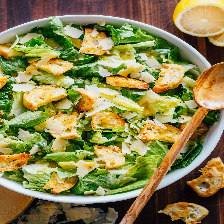

In [82]:
tf.keras.preprocessing.image.load_img(img_path, target_size = (IMG_HEIGHT, IMG_WIDTH))


In [83]:
def load_img_predict(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = (IMG_HEIGHT, IMG_WIDTH))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    img = np.expand_dims(img, axis = 0)
    
    return img

In [84]:
clf_final.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 3,572,803
Trainable params: 1,314,819
Non-trainable params: 2,257,984
_________________________________________________________________


In [85]:
def predict_image(img_path,classifier):
    img = load_img_predict(img_path)
    res = clf_final.predict(img)

    res = sorted (
        list(zip ( 
            list_of_classes
            , np.squeeze(res)
         )
        )
     , key=lambda x: x[1]   
     , reverse=True
    )
    
    return res

In [86]:
predict_image(img_path,clf_final)[:15]

[('caesar_salad', 0.999899),
 ('falafel', 9.851342e-05),
 ('apple_pie', 2.5378667e-06)]

# Download Assets
download model and classes.json

In [87]:
!zip -r {PROJECT_NAME}/artifacts/artifacts.zip {PROJECT_NAME}/artifacts/

  adding: project_food_dl/artifacts/ (stored 0%)
  adding: project_food_dl/artifacts/classes.json (deflated 5%)
  adding: project_food_dl/artifacts/model_ResNet50.h5 (deflated 7%)
  adding: project_food_dl/artifacts/model_MobileNet.h5 (deflated 7%)
  adding: project_food_dl/artifacts/model_VGG19.h5 (deflated 7%)


In [89]:
from google.colab import files
files.download(str(str(PROJECT_NAME)+"/artifacts/artifacts.zip"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>